In [1]:
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

import sys
sys.path.append('..')
from lib import *
from numba import njit

plt.style.use('../peptidome.mplstyle')

In [2]:
proteome = 'Humanviruses'
all_data = {}
for i, model in enumerate(['independent', 'ncov', 'nskew', 'nskewfcov']):

    arr = np.load('data/{proteome}_{model}_k9_likelihoods.npz'.format(proteome=proteome, model=model))
    df = pd.read_csv('../maxent/data/{proteome}_{model}_k9_dkl.csv'.format(proteome=proteome, model=model),
                     index_col=0, squeeze=True)
    dkl = df.loc['DKL']
    data = {}

    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph

    positive = logp_pp-logp_ph
    negative = logp_hp-logp_hh
    data['positive'] = np.sort(positive)*np.log10(np.exp(1))
    data['negative'] = np.sort(negative)*np.log10(np.exp(1))
    data['dkl'] = dkl
    
    all_data[model] = data

In [3]:
np.mean(all_data['nskewfcov']['positive'])/np.log10(np.exp(1)), all_data['nskewfcov']['dkl']

(0.15691053492722834, 0.17817676201696386)

Text(0, 0.5, '# peptides')

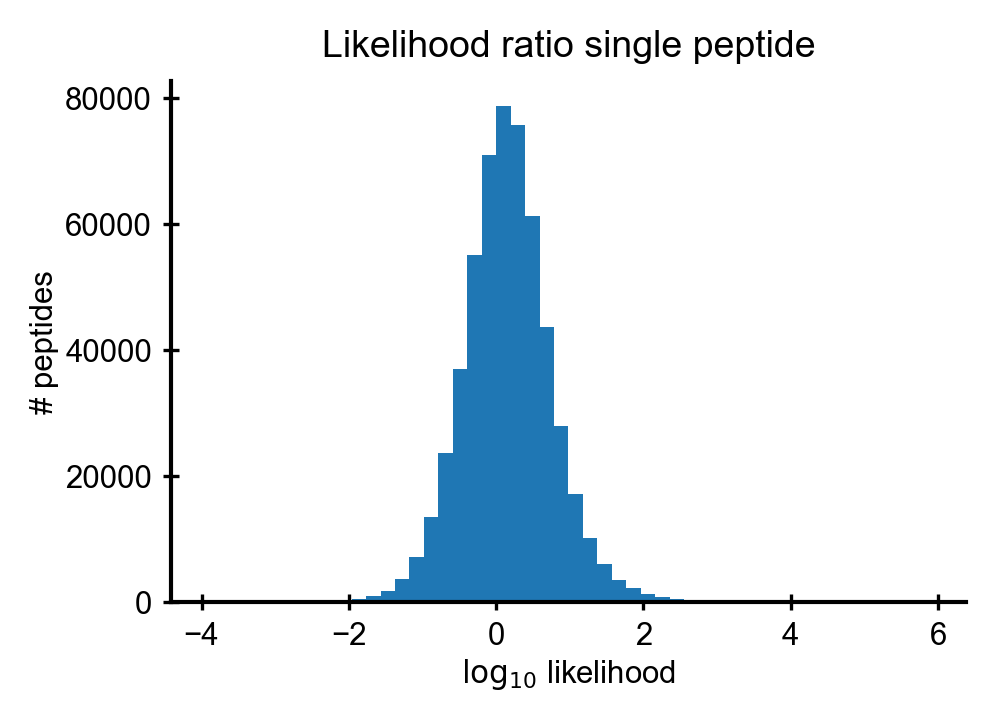

In [4]:
plt.title('Likelihood ratio single peptide')
plt.hist(positive, bins=50);
plt.xlabel('$\log_{10}$ likelihood')
plt.ylabel('# peptides')

In [5]:
positive = all_data['nskewfcov']['positive']
Npeptides = 100
Ndraws = 10000
draws = np.random.choice(positive, size=(Ndraws, Npeptides))
likelihood_ratio = np.sum(draws, axis=1)

Text(0.5, 0, '$log_{10}$ likelihood')

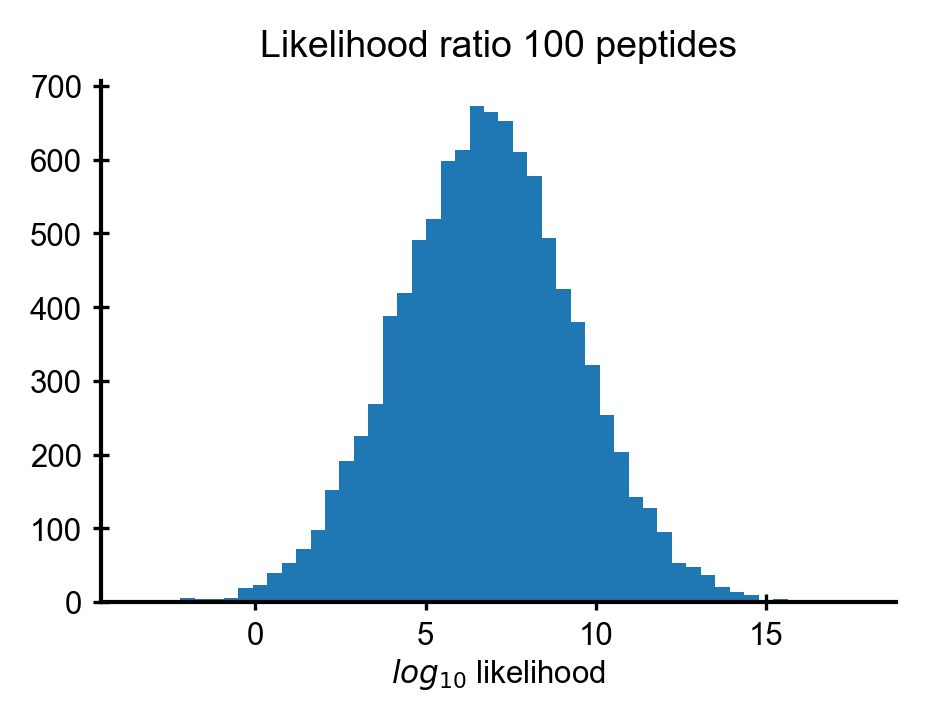

In [6]:
plt.title('Likelihood ratio 100 peptides')
plt.hist(likelihood_ratio, bins=50)
#plt.axvline(all_data['nskewfcov']['dkl']*Npeptides*np.log10(np.exp(1)), color='k')
plt.xlabel('$log_{10}$ likelihood')

In [7]:
def calculate_threshold(alpha, Ndraws=1e6, Npeptides=1, negative=all_data['nskewfcov']['negative']):
    """ Calculate likelihood ratio threshold at a given alpha level.
    """
    Ndraws = int(Ndraws)
    Npeptides = int(Npeptides)
    draws = np.random.choice(negative, size=(Ndraws, Npeptides))
    likelihood_ratio = np.sum(draws, axis=1)
    return np.sort(likelihood_ratio)[-int(alpha * len(likelihood_ratio))]

In [8]:
calculate_threshold(1e-3, Ndraws=1e5, Npeptides=100)

0.5366942425515876

In [9]:
thresholds = [1, 2, 3, 4, 5, 6]
positive = all_data['nskewfcov']['positive']
Ndraws = 10000

Npeptidess = np.logspace(0, 2.5, 30)#[1, 2, 5, 10, 20, 50, 100, 200, 500]
p_detections = np.zeros(shape=(len(thresholds), len(Npeptidess)))
for i, threshold in enumerate(thresholds):
    for j, Npeptides in enumerate(Npeptidess):
        Npeptides = int(Npeptides)
        draws = np.random.choice(positive, size=(Ndraws, Npeptides))
        likelihood_ratio = np.sum(draws, axis=1)
        likelihood_threshold = calculate_threshold(10**-threshold, Ndraws=1e5, Npeptides=Npeptides)
        print(threshold, Npeptides, likelihood_threshold)
        p_detection = np.sum(likelihood_ratio > likelihood_threshold)/Ndraws
        p_detections[i, j] = p_detection

1 1 0.24283239042888347
1 1 0.24260656901624192
1 1 0.24055301191430045
1 1 0.24032975660168943
1 2 0.31171227667064627
1 2 0.3097158774105355
1 3 0.3457691861061385
1 4 0.3612779179479496
1 4 0.3600394463927194
1 5 0.36895671744006076
1 7 0.3563266213303797
1 8 0.3430151649371261
1 10 0.30377314487334134
1 13 0.23389377753437357
1 16 0.13546926183551655
1 19 0.038176728470416754
1 23 -0.11753646312895105
1 29 -0.3703219872769432
1 35 -0.6682906835090802
1 43 -1.0554628642531942
1 52 -1.5345176698548735
1 64 -2.2065159112757367
1 78 -3.0136899757979863
1 96 -4.058714104261224
1 117 -5.326690533128153
1 142 -6.927232374933146
1 174 -8.9784432633195
1 212 -11.485083822151706
1 259 -14.605978493841604
1 316 -18.489159980282743
2 1 0.5373830217519477
2 1 0.5310767710010579
2 1 0.5379514885563156
2 1 0.5337287519934358
2 2 0.7049191460297677
2 2 0.7038086554387373
2 3 0.810254657134319
2 4 0.9119703315054486
2 4 0.9226266022365806
2 5 0.989784505328763
2 7 1.0816953727545258
2 8 1.112887083

Text(0.5, 0, 'Number of samples')

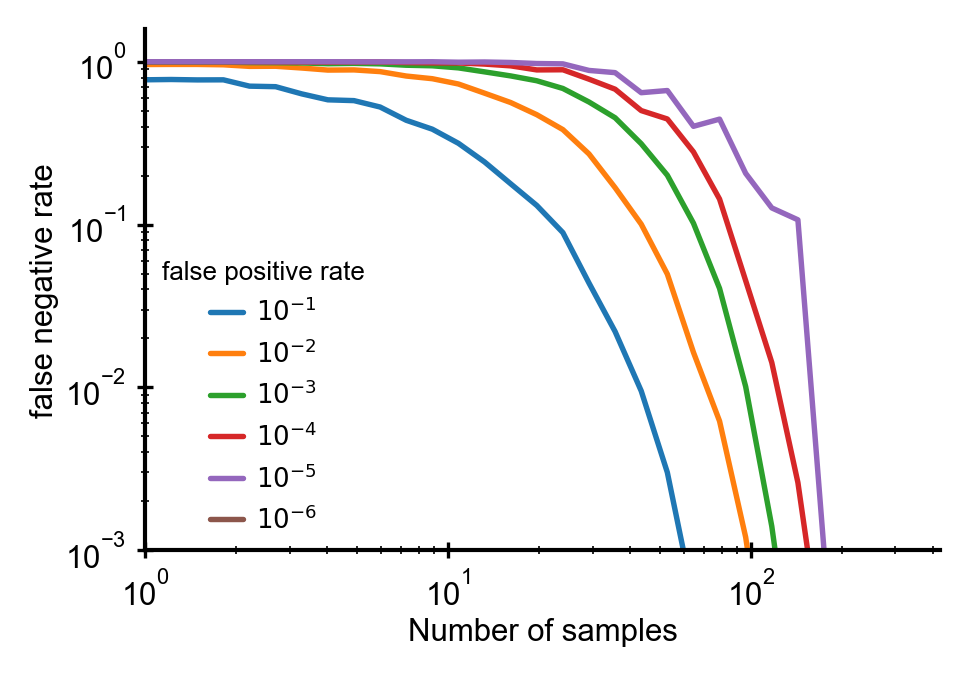

In [10]:
for i, threshold in enumerate(thresholds):
    plt.plot(Npeptidess, 1-p_detections[i, :], '-', label='$10^{-%g}$'%threshold)
plt.legend(title='false positive rate')
#plt.axvline(threshold/(all_data['nskewfcov']['dkl']*np.log10(np.exp(1))), color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.0)
plt.ylim(bottom=1e-3)
plt.ylabel('false negative rate')
plt.xlabel('Number of samples')

In [11]:
alpha = 1e-3
positive = all_data['nskewfcov']['positive']
negative = all_data['nskewfcov']['negative']
Ndraws = int(1e5)
recalls =  np.logspace(0, -2, 25)

Npeptidess = np.logspace(0, 2.3, 50)#[1, 2, 5, 10, 20, 50, 100, 200, 500]
Npeptidess = np.unique([int(N) for N in Npeptidess])
p_detections = np.zeros(shape=(len(recalls), len(Npeptidess)))
for i, recall in enumerate(recalls):
    for j, Npeptides in enumerate(Npeptidess):
        Npeptides = int(Npeptides)
        top = positive[-int(recall*len(positive)):]
        draws = np.random.choice(top, size=(Ndraws, Npeptides))
        likelihood_ratio = np.sum(draws, axis=1)
        # need to calculate likelihood threshold by also restricting negative examples to the same subspace
        top_negative = negative[-int(recall*len(negative)):]
        likelihood_threshold = calculate_threshold(alpha, Ndraws=1e5,
                                                   Npeptides=Npeptides, negative=top_negative)
        #print(recall, Npeptides, likelihood_threshold)
        p_detection = np.sum(likelihood_ratio > likelihood_threshold)/Ndraws
        p_detections[i, j] = p_detection

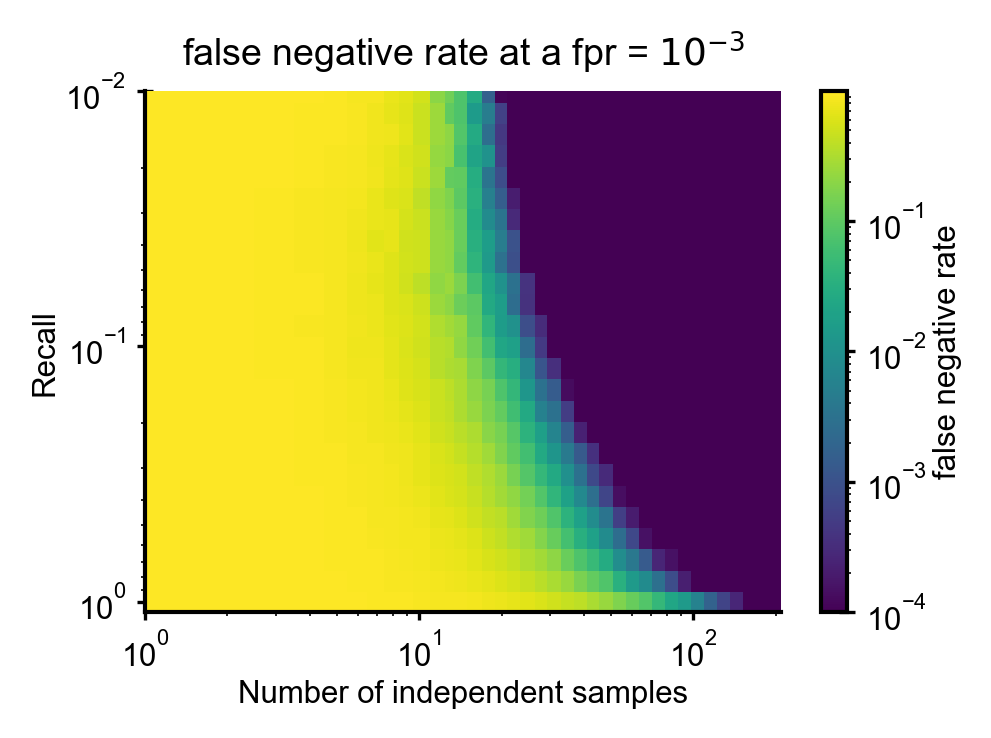

In [13]:
plt.title('false negative rate at a fpr = $10^{-3}$')
plt.pcolormesh(Npeptidess, recalls, 1-p_detections+1e-10,
               norm=matplotlib.colors.LogNorm(vmin=1e-4), shading='nearest')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='false negative rate')
plt.xlim(1.0)
plt.ylim(1.1e0, 1e-2)
plt.xlabel('Number of independent samples')
plt.ylabel('Recall')
plt.savefig('quorum_requirement.pdf')